<a href="https://colab.research.google.com/github/ArtemyTimofeev/pr3/blob/master/Exercise_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2: Solving the Poisson Equation
![image.png](attachment:image.png)

In this exercise, we will solve the Poisson equation with FEniCS:

\begin{alignat}{2}
-\Delta u &= f \quad && \text{ in } \Omega \\
u &= u_{\mathrm{D}} \quad && \text{ on } \Gamma_{\mathrm{D}} \\
-\partial_n u &= g \quad && \text{ on } \Gamma_{\mathrm{N}}
\end{alignat}

We will use the following data:

* $\Omega = (S_0 \cup S_1) \setminus (C_0 \cup C_1)$
* $S_0$ is the unit square centered at $(0.5, 0.5)$
* $S_1$ is the unit square centered at $(1, 1)$
* $C_0$ is a circle with radius $0.25$ centered at $(0.5, 0.5)$
* $C_1$ is a circle with radius $0.25$ centered at $(1, 1)$
* $\Gamma_{\mathrm{D}} = $ the boundaries of the two circles
* $\Gamma_{\mathrm{N}} = \partial\Omega \setminus \Gamma_{\mathrm{D}}$
* $f(x, y) = \exp(-10((x - 0.75)^2 + (y - 0.75)^2))$
* $u_{\mathrm{D}} = 0$
* $g = 0$

![poisson_domains.png](attachment:poisson_domains.png)

For hints and more reading on how to solve the Poisson problem in FEniCS, see the [section on the Poisson problem](https://fenicsproject.org/pub/tutorial/html/._ftut1004.html#ch:fundamentals) in the [FEniCS Tutorial](https://fenicsproject.org/tutorial/).

## Importing FEniCS
The first thing we need to do is to import FEniCS. We will also need to import the meshing library `mshr`.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
!mamba install -y -c conda-forge h5py
!mamba install -y -c conda-forge fenics
!mamba install -y -c conda-forge mshr

!pip install meshio
!conda install -y -c conda-forge paraview

!mkdir -p /usr/include
!ln -s /usr/local/include/ufc.h /usr/include/ufc.h
!ln -s /usr/local/include/ufc_geometry.h /usr/include/ufc_geometry.h


Looking for: ['h5py']

[+] 0.0s
conda-forge/linux-64  ⣾  [+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   2%
conda-forge/noarch     3%[+] 0.3s
conda-forge/linux-64  11%
conda-forge/noarch    22%[+] 0.4s
conda-forge/linux-64  18%
conda-forge/noarch    42%[+] 0.5s
conda-forge/linux-64  25%
conda-forge/noarch    55%[+] 0.6s
conda-forge/linux-64  30%
conda-forge/noarch    66%[+] 0.7s
conda-forge/linux-64  33%
conda-forge/noarch    79%[+] 0.8s
conda-forge/linux-64  40%
conda-forge/noarch    86%[+] 0.9s
conda-forge/linux-64  43%
conda-forge/noarch    94%conda-forge/noarch                                
[+] 1.0s
conda-forge/linux-64  47%[+] 1.1s
conda-forge/linux-64  59%[+] 1.2s
conda-forge/linux-64  71%[+] 1.3s
conda-forge/linux-64  82%[+] 1.4s
conda-forge/linux-64  92%[+] 1.5s
conda-forge/linux-64  98%conda-forge/linux-64                              

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-ver

In [3]:
import dolfin
import mshr


print("dolfin version:", dolfin.__version__)
print("mshr loaded successfully")

dolfin version: 2019.1.0
mshr loaded successfully


/usr/local/lib/python3.11/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):


In [4]:
# Installing and Importing Fenics
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2019.1.0


<ipython-input-4-d6d32d71da46>:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if ( LooseVersion(python_version) < LooseVersion("3.0.0")):


In [5]:
from fenics import *

## Initializing notebook plotting
When running in a Jupyter notebook, a special line is necessary to show FEniCS plots in the notebook.

In [6]:
%matplotlib inline

## Creating the mesh
To create the mesh, use boolean operators (CSG = Constructive Solid Geometry) from `mshr`. Define the two squares and circles, then combine them with operators `+` (union), `*` (intersection) and `-` (set difference). (Only union and set difference will be needed for this exercise.)

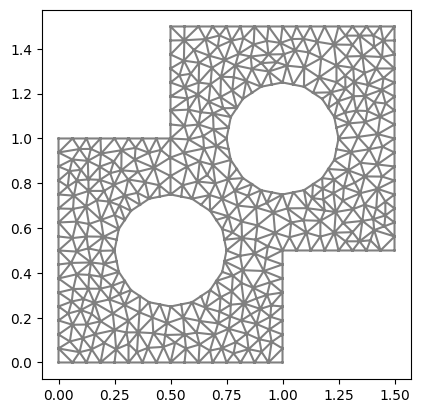

In [7]:
S0 = Rectangle(Point(0, 0), Point(1, 1))
S1 = Rectangle(Point(0.5,0.5),Point(1.5,1.5))
C0 = Circle(Point(0.5,0.5),0.25)
C1 = Circle(Point(1,1),0.25)
domain = (S0+S1)-(C0+C1)
mesh = generate_mesh(domain,20)
plot(mesh)

## Defining the finite element function space
When we have created the mesh, we can define the finite element function space. We will use a standard piecewise linear $P_1$ function space.

In [8]:
V = FunctionSpace(mesh,'P',1)

Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/local/lib/python3.11/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:
------------------- Start compiler output ------------------------
In file included from /usr/include/features.h:392,
                 from /usr/local/lib/gcc/x86_64-conda-linux-gnu/12.4.0/include/c++/x86_64-conda-linux-gnu/bits/os_defines.h:39,
                 from /usr/local/lib/gcc/x86_64-conda-linux-gnu/12.4.0/include/c++/x86_64-conda-linux-gnu/bits/c++config.h:662,
                 from /usr/local/lib/gcc/x86_64-conda-linux-gnu/12.4.0/include/c++/bits/stl_algobase.h:59,
                 from /usr/local/lib/gcc/x86_64-conda-linux-gnu/12.4.0/include/c++/algorithm:60,
                 from /tmp/tmpfbiuyy5v/ffc_element_2d4ff644b3dd83803fb1e898ba9f33b754e32fa8.h:31,
                 from /tmp/tmpfbiuyy5v/ffc_element_2d4ff644b3dd83803fb1e898ba9f33b754e32fa8.cpp:29

DijitsoError: Dijitso JIT compilation failed, see '/content/jitfailure-ffc_element_2d4ff644b3dd83803fb1e898ba9f33b754e32fa8' for details

## Defining the boundary condition
The boundary condition can be defined by specifying all points on the boundary closer to either of the two circle centers than a distance slightly larger than the radius $r = 0.25$.

In [ ]:
def boundary(x, on_boundary):
    d0 = sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    d1 = sqrt((x[0]-1.0)**2 + (x[1]-1.0)**2)
    return on_boundary and (d0 < 0.3 or d1 < 0.3)

bc = DirichletBC(V, 0 , boundary)

## Defining the variational problem
The finite element variational problem for the Poisson equation reads: Find $u \in V$ such that
$$
\int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x = \int_{\Omega} fv \,\mathrm{d}x
$$
for all $v \in V$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega} fv \,\mathrm{d}x.
\end{align}

In [ ]:
u = TrialFunction(V)
v = TestFunction(V)
f = Expression('exp(-10.0*(pow(x[0]-0.75,2) + pow(x[1] - 0.75,2)))',degree = 2)
a = inner(grad(u), grad(v))*dx
L = f*v*dx

## Solving the variational problem
The variational problem can now be solved by calling the FEniCS `solve` command. Use the `plot` command to visualize the solution.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


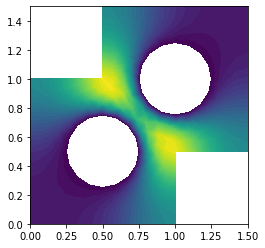

In [ ]:
u = Function(V)
solve(a == L, u, bc)
plot(u)

## Postprocessing
To postprocess the solution using an external postprocessor, for example Paraview, save the solution to VTK format (file suffix `.pvd`).